In [1]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import warnings
warnings.filterwarnings("ignore")

from models import matting_net

def convert_checkpoint_into_tflite(h5_path=None,
                                   output_path=None,
                                   android=True):
    if android:
        model = matting_net((256,256,4), android=True)
        
    else:
        model = matting_net((256,256,3), android=False)
    # model 명 과 상세사항 정리해두기 
    model.load_weights(h5_path, by_name=True)

    input_names = [node.op.name for node in model.inputs]
    output_names = [node.op.name for node in model.outputs]
    print(input_names)
    print(output_names)

    sess = K.get_session()
    converter = tf.lite.TFLiteConverter.from_session(sess, model.inputs, model.outputs)

    tflite_model = converter.convert()
    open(output_path, "wb").write(tflite_model)
    print("tflite successfully built")
    
    return model

Using TensorFlow backend.
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
tf.__version__

'1.14.0'

In [3]:
model = convert_checkpoint_into_tflite(h5_path="./trained_models/20191212/30.h5",
                                       output_path="./tflite/20191212_30_real.tflite", 
                                       android=True)

['input_1']
['output/Sigmoid']
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 166 variables.
INFO:tensorflow:Converted 166 variables to const ops.
tflite successfully built


## Model output test

In [4]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:]
img = img / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

pred = model.predict(img)

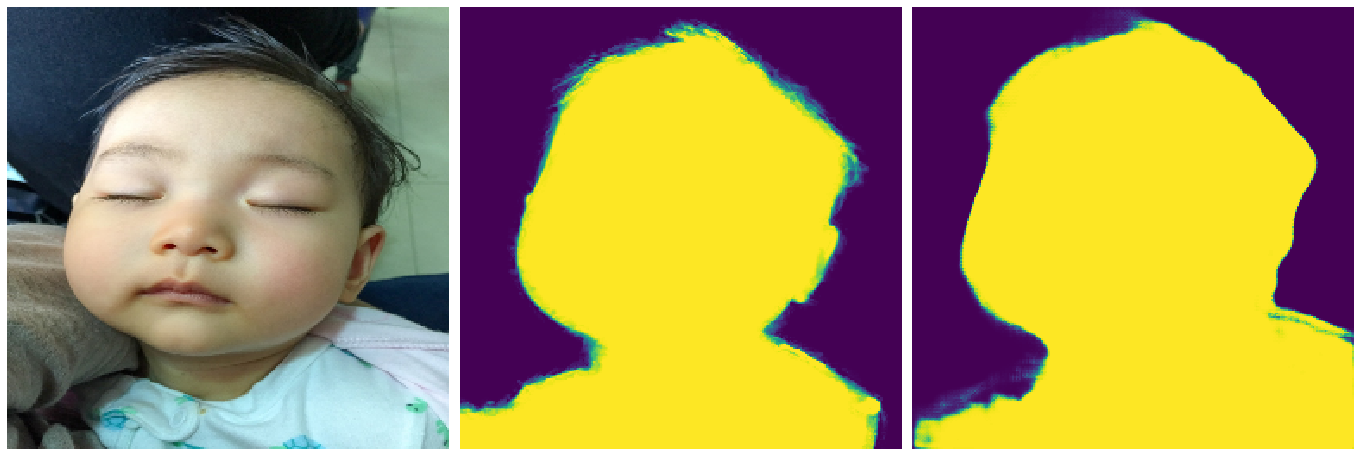

In [5]:
plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(132)
plt.imshow(mask)
plt.axis("off")

plt.subplot(133)
plt.imshow(pred.squeeze(0).squeeze(-1) * 255)
plt.axis("off")

plt.tight_layout()
plt.show()

(-0.5, 255.5, 255.5, -0.5)

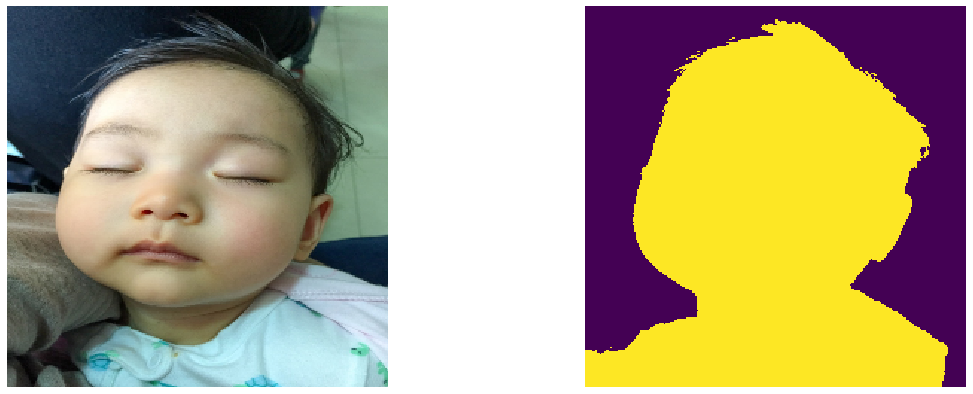

In [37]:
plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(cv2.threshold(mask, 90, 255, cv2.THRESH_BINARY)[1])
plt.axis("off")

### Model Output test 2

In [6]:
from sklearn.metrics import confusion_matrix  

def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [7]:
mask_ = cv2.threshold(mask, 255/2, 255, cv2.THRESH_BINARY)
pred_ = cv2.threshold(pred.squeeze(0).squeeze(-1), 0.5, 1, cv2.THRESH_BINARY)
compute_iou(mask_[1], pred_[1])

0.4010139938636534

In [8]:
import numpy as np
from sklearn.metrics import log_loss

def cross_entropy(y_true, y_pred):
#     y_true = y_true.flatten()
#     y_pred = y_pred.flatten()
    
    N = y_pred.shape[0]# * y_pred.shape[1]
    
    ce = -np.sum(y_true*np.log(y_pred + 1e-5)) / N
    
    return ce


ce = cross_entropy(mask, pred.squeeze(0).squeeze(-1))

ce

2225.01953125

In [9]:
train_params = {
            'dim': (256,256),
            'batch_size': 32,
            'n_channels': 3,
            'shuffle': True,
            'augment': True,
        }

In [10]:
img_paths = np.load("./dataset/img_paths.npy")

train_img_paths = np.random.choice(img_paths, int(img_paths.shape[0] * 0.8), replace=False)

test_img_paths = np.setdiff1d(img_paths, train_img_paths)

In [11]:
from data_generator import DataGeneratorMatting
train_gen = DataGeneratorMatting(train_img_paths, **train_params)

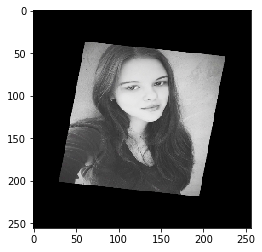

In [43]:
sample = train_gen[0]
sample_tre = sample[0][11]
sample_mas = sample[1][11].squeeze(-1)
plt.imshow(sample_tre)

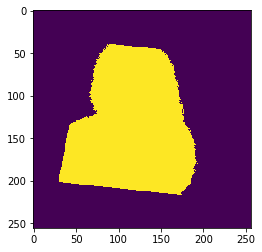

In [44]:
plt.imshow(sample_mas)

In [14]:
preds = model.predict(np.concatenate((train_gen[0][0], np.ones((32, 256, 256, 1))), axis=-1))

In [15]:
train_gen[0][0].shape

(32, 256, 256, 3)

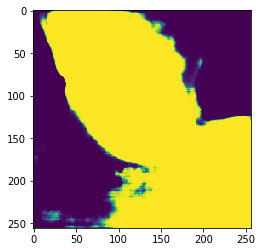

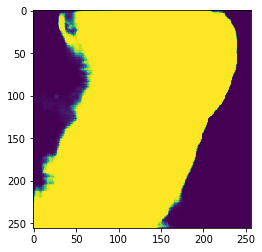

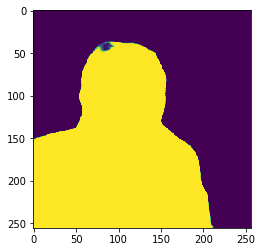

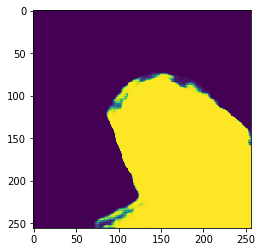

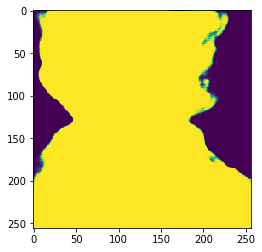

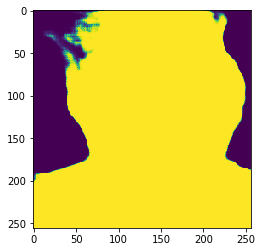

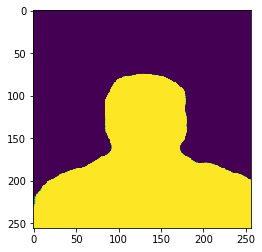

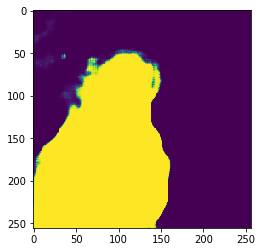

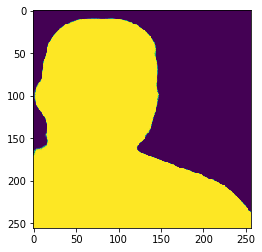

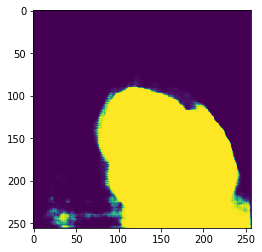

In [16]:
for pr in preds[10:20]:
    plt.imshow(pr.squeeze(-1))
    plt.show()

In [17]:
res = list(map(lambda x: cross_entropy(x[0], x[1]), zip(train_gen[0][1], preds)))
print(np.mean(res))

572.1410562467771
